## Import and directories

In [1]:
#directories
import os
try:
    parentdir
except NameError:
    parentdir=os.getcwd()
else:
    parentdir = parentdir
# homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';#data directory
print('The working directory is parentdir: %s' %parentdir)
# print('The data directory is homedir: %s' %homedir)
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
download = r'/home/biswajit/Downloads'

The working directory is parentdir: /home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Manuscript/Figure


In [2]:
#Run this once to run the .py(Analysis_bis.py) file.
os.chdir(r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Analysis')
!python Analysis_bis.py
%run Analysis_bis.py

In [3]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "11"

## Setup Schematic: Figure_1

## Time trace: Figure_2

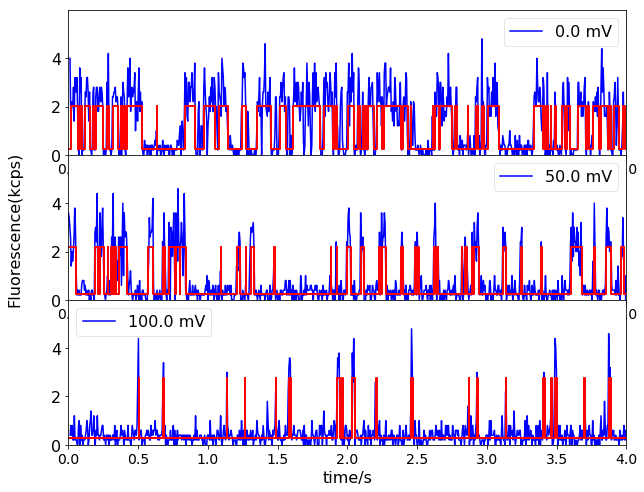

In [21]:
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
fig = time_trace_plot(foldername= folder, input_potential=[0, 50, 100], pointnumbers=[1], x_lim_min=0, y_lim_min=0, x_lim_max=4, y_lim_max=6, bin=5, show_changepoint=False)
os.chdir(parentdir)
savefig('Figure_2part_timetrace.pdf', dpi=300, transparent=True)

## Toff/Ton plot_Nernst fit: Figure_3a

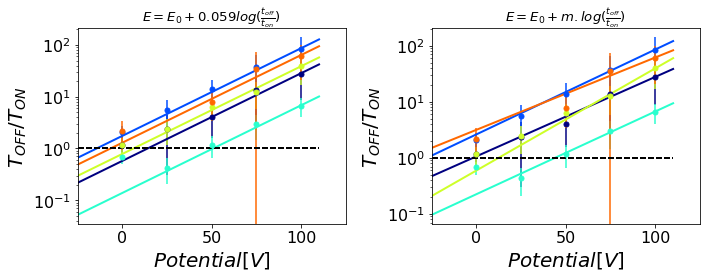

In [39]:
def Mid_potentials_slopem(folderpath=foldername, pointnumbers=range(20), plotting=True, min_pot=40, min_pot_num=1):
    timetrace_output = timetrace_outputs_folderwise(folderpath=folderpath, pointnumbers=pointnumbers, potentialist=potentialist)
    def nernst(x, a):
        '''x is potential
        a: E0/midpoint potential(parameter)
        returns ratio(t_oxd/t_red)'''
        return(10**((x - a) / 0.059))
    def nernst_slopem(x, a, m):
        return(10**((x - a) / m))
    columns_E0 = ['Point number', 'E0_fit', 'E0_err']
    columns_E0_m = ['Point number', 'E0_fit', 'E0_err', 'slope', 'slope_error']
    E0_list = pd.DataFrame(index=None, columns=columns_E0)
    E0_m_list = pd.DataFrame(index=None, columns=columns_E0_m)
    #--figure initiation----
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        cmap = plt.get_cmap('jet')#jet_r
        N=len(timetrace_output.columns.levels[0])
    for i in range(len(timetrace_output.columns.levels[0])):
        point = timetrace_output.columns.levels[0][i]
        point_output_tot = timetrace_output[point].dropna()
        point_output = point_output_tot[point_output_tot['Potential'] >= min_pot] #select a potential threshold
        if len(point_output) > min_pot_num:
            potential = point_output['Potential']
            t_onav = point_output['t_onav']
            t_onaverr = point_output['t_onaverr']
            t_offav = point_output['t_offav']
            t_offaverr = point_output['t_offaverr']
            t_ratio = point_output['t_ratio']
            t_ratioerr = point_output['t_ratioerr']
            E = potential*0.001 #converting to mV
            #--------fitting nernst----------------
            E0_fit, E0_var = curve_fit(nernst, E, t_ratio, p0=0.02)
            E0_err = np.sqrt(np.diag(E0_var));
            E0 = E0_fit[0]; E0_err=E0_err[0]
            #---------append to list---------
            E0_list_temp = pd.DataFrame([[point, E0, E0_err]], columns=columns_E0)
            E0_list=E0_list.append(E0_list_temp, ignore_index=True)
            #--------fitting nernst_slopem------
            E0_m_fit, E0_m_var = curve_fit(nernst_slopem, E, t_ratio, p0=[0.02, 0.059])
            E0_m_err = np.sqrt(np.diag(E0_m_var))
            E0_m = E0_m_fit[0];E0_m_fit_err = E0_m_err[0];
            slope_m = E0_m_fit[1]; slope_m_err = E0_m_err[1];
            E0_m_list_temp = pd.DataFrame([[point, E0_m, E0_m_fit_err, slope_m, slope_m_err]], columns=columns_E0_m)
            E0_m_list = E0_m_list.append(E0_m_list_temp, ignore_index=True)
            #-----plot------
            if plotting == True:
                color = cmap(float(i)/N)
                axes[0].errorbar(point_output_tot['Potential'], point_output_tot['t_ratio'],
                         yerr=point_output_tot['t_ratioerr'], fmt='o', color=color, label=point, ms=5)#plot raw outputs
                axes[0].plot(linspace(-25, max(potential)+10), nernst(0.001*linspace(-25, max(potential)+10), *E0_fit), color=color, linewidth=2)#color
                axes[0].plot(linspace(-25, max(potential)+10), ones(len(linspace(-25, max(potential)+10))), '--k', linewidth=2)
                #plot(E*1000, nernst(E, *E0_fit), color=color, linewidth=2.0)

                
                axes[1].errorbar(point_output_tot['Potential'], point_output_tot['t_ratio'],
                         yerr=point_output_tot['t_ratioerr'], fmt='o', color=color, label=point, ms=5)#plot raw outputs
                axes[1].plot(linspace(-25, max(potential)+10), nernst_slopem(0.001*linspace(-25, max(potential)+10), *E0_m_fit), color=color, linewidth=2)
                axes[1].plot(linspace(-25, max(potential)+10), ones(len(linspace(-25, max(potential)+10))), '--k', linewidth=2)
                
                axes[0].set_yscale('log')
                axes[0].set_xlim(-25, 125)
                axes[0].set_xlabel('$Potential [V]$', fontsize=20)
                axes[0].set_ylabel('$T_{OFF}/T_{ON}$', fontsize=20)
                axes[0].tick_params(axis='both', which='major', labelsize=16)
                axes[0].set_title(r'$E=E_0 + 0.059log(\frac{t_{off}}{t_{on}})$')
                
                axes[1].set_yscale('log')
                axes[1].set_xlabel('$Potential [V]$', fontsize=20)
                axes[1].set_ylabel('$T_{OFF}/T_{ON}$', fontsize=20)
                axes[1].tick_params(axis='both', which='major', labelsize=16)
                axes[1].set_title(r'$E=E_0 + m.log(\frac{t_{off}}{t_{on}})$')
                axes[1].set_xlim(-25, 125)
                
                tight_layout()
                #legend(bbox_to_anchor=(0.9, 0.3), fontsize=16)
    return(E0_list, E0_m_list)
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
E0_list, E0_m_list = Mid_potentials_slopem(folderpath=folder, pointnumbers=[3, 4, 10, 14, 16], plotting=True, min_pot=25, min_pot_num=1)
os.chdir(parentdir)
savefig('Figure_2part_Nernstplot.pdf', dpi=300, transparent=True)

## Histogram_E0: Figure_3b

In [40]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655]
#Calculate midpoint potential of all points in all folders
E0_array = pd.DataFrame(index=None, columns=['Point number', 'E0_fit', 'E0_err'])
E0_m_array = pd.DataFrame(index=None, columns=['Point number', 'E0_fit', 'E0_err', 'slope', 'slope_error'])
for folder in allfolders:
    E0_list, E0_m_list = Mid_potentials_slopem(folderpath=folder, pointnumbers=range(50), plotting=False, min_pot=25)
    E0_array = E0_array.append(E0_list, ignore_index=True)
    E0_m_array = E0_m_array.append(E0_m_list, ignore_index=True)

em.plot file: Point_0.11uW_A5_150mV(64)_7.pt3.datn.em.plot doesnt contain proper data
em.plot file of Point_2 with potential 100.0 doesnt exist
em.plot file of Point_14 with potential 45.0 doesnt exist
em.plot file of Point_15 with potential 100.0 doesnt exist


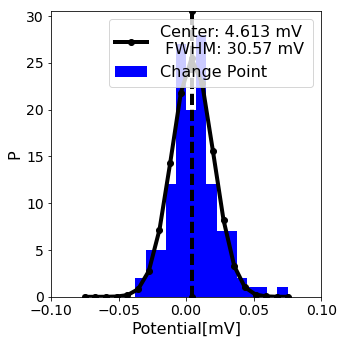

In [42]:
#MIDPOTENTIAL HISTGRAM FITTING/ PLOTTING
fig, axes = subplots(figsize=(5, 5))
# plt.figure()
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "14"
min_range = -0.075
max_range = 0.075
range_fit = [min_range, max_range]
bins = 20
bin_centers_on = linspace(range_fit[0], range_fit[1], bins)
x=linspace(range_fit[0], range_fit[1], 100)# for a smooth fitting plot include more points

from scipy.interpolate import interp1d
from lmfit.models import GaussianModel
mod = GaussianModel()
# params = gmodel.make_params(center=0.01, amplitude=10, sigma=0.02)
#Change point--------------------------
n,bins_on1,patches = axes.hist(E0_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder
y=n; x=bin_centers_on;
result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
temp =result1.best_values
FWHM = 2*temp['sigma']*1000 #V
cent = temp['center']*1000#eV
amp = temp['amplitude']

axes.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
amp = temp['amplitude']
height = 0.3989423*amp/max(1.e-15, temp['sigma'])
axes.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

axes.set_xlim(-0.1, 0.1)
axes.set_ylim(0,height+0.2*height)
axes.set_ylabel('P', fontsize=16)
axes.set_xlabel('Potential[mV]', fontsize=16)
axes.legend(fontsize=16)

fig.tight_layout()
# os.chdir(homedir)
# fig.savefig('/home/biswajit/Pictures/canters_temp/MidpointPotential_distribution.pdf', dpi=300, transparent=True)
# figure()
# result.plot()
os.chdir(download)
savefig('FigPart_3b_E0_hist.pdf', dpi=300, transparent=True)
result1.fit_report()

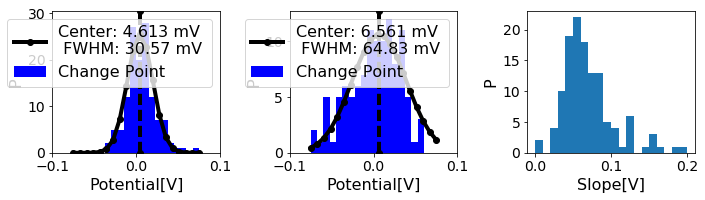

In [14]:
#MIDPOTENTIAL HISTGRAM FITTING
def plot_midpoint_hist(E0_array, E0_m_array):
    fig = plt.figure(figsize=(10, 3))
    # plt.figure()
    mpl.rcParams["font.family"] = "sans-serif"
    mpl.rcParams["font.size"] = "14"
    min_range = -0.075
    max_range = 0.075
    range_fit = [min_range, max_range]
    bins = 20
    bin_centers_on = linspace(range_fit[0], range_fit[1], bins)
    x=linspace(range_fit[0], range_fit[1], 100)# for a smooth fitting plot include more points

    from scipy.interpolate import interp1d
    from lmfit.models import GaussianModel
    mod = GaussianModel()
    # params = gmodel.make_params(center=0.01, amplitude=10, sigma=0.02)
    #Change point--------------------------
    ax1 = fig.add_subplot(1,3,1)#2,2,1
    n,bins_on1,patches = ax1.hist(E0_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder
    y=n; x=bin_centers_on;
    result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
    temp =result1.best_values
    FWHM = 2*temp['sigma']*1000 #V
    cent = temp['center']*1000#eV
    amp = temp['amplitude']

    ax1.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
    amp = temp['amplitude']
    height = 0.3989423*amp/max(1.e-15, temp['sigma'])
    ax1.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

    ax1.set_xlim(-0.1, 0.1)
    ax1.set_ylim(0,height+0.2*height)
    ax1.set_ylabel('P', fontsize=16)
    ax1.set_xlabel('Potential[V]', fontsize=16)
    ax1.legend(fontsize=16)
    #-----
    ax2 = fig.add_subplot(1,3,2)
    n,bins_on1,patches = ax2.hist(E0_m_array['E0_fit'], bins = bins, range=range_fit, color='b', label='Change Point')#E0_list from running all folder

    y=n; x=bin_centers_on;
    result1 = mod.fit(y, center=0.01, amplitude=10, sigma=0.02, x=x)
    temp =result1.best_values
    FWHM = 2*temp['sigma']*1000 #V
    cent = temp['center']*1000#eV
    amp = temp['amplitude']

    ax2.plot(x, result1.best_fit, '-ko', lw=4, label='Center: %.3f mV \n FWHM: %.2f mV' %(cent, FWHM))
    amp = temp['amplitude']
    height = 0.3989423*amp/max(1.e-15, temp['sigma'])
    ax2.plot([cent*0.001, cent*0.001], [0, height+0.2*height], '--ok', lw=4)

    ax2.set_xlim(-0.1, 0.1)
    ax2.set_ylim(0,height+0.2*height)
    ax2.set_ylabel('P', fontsize=16)
    ax2.set_xlabel('Potential[V]', fontsize=16)
    ax2.legend(fontsize=16)
    #-----
    ax3 = fig.add_subplot(1,3,3)
    n,bins_on1,patches = ax3.hist(E0_m_array['slope'], bins = 20, range=(0, 0.2))#, range=range_fit, color='b', label='Change Point'
    # ax3.plot(E0_m_array['E0_fit']*1000, E0_m_array['slope'], )
    # ax3.set_xlim(-0.1, 0.1)
    # ax3.set_ylim(0,height+0.2*height)
    ax3.set_ylabel('P', fontsize=16)
    ax3.set_xlabel('Slope[V]', fontsize=16)
    # ax3.legend(fontsize=16)

    fig.tight_layout()
    # os.chdir(homedir)
    # fig.savefig('/home/biswajit/Pictures/canters_temp/MidpointPotential_distribution.pdf', dpi=300, transparent=True)
    # figure()
    # result.plot()
    return()
plot_midpoint_hist(E0_array, E0_m_array)
SI_figure=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/Azurin_SM_repo/Manuscript/Figure_SI'
os.chdir(SI_figure)
savefig('SI_potential_histogram_Cu.pdf', dpi=300, transparent=True)

## Many SM histogram

In [100]:
#list of folders and their directories CuAZUATTO655
S81d7Sept16_A3_ON_60sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A3_ON/60sec_trace';
S81d7Sept16_A5_ON = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160907_CuAzu655_Ferri_Asc_analysis/S81d7Sept16_0.11uW_0.2mMFerri_0.1mM Asc_A5_ON';
S83d10Sept16_A3_30sec_trace = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/30sec_trace'
S83d10Sept16_Cu_50mV_300s = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201609/20160910_CuAzu655Ferri_asc_2ndtime/S83d10Sept16_CuAz655_0.1mMAsc_0.2mMFerri_0.11uW_A3/300sec_trace';

S101d14Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d14Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_60.5_635_A2_CuAzu655';
S101d15Feb17_62o2_635_A2_CuAzu655_2nd= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d15Feb17_62.2_635_A2_CuAzu655_2nd';
S101d16Feb17_60o5_635_A3_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S101d16Feb17_60.5_635_A3_CuAzu655';
S104d20Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d20Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A1_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A1_CuAzu655';
S104d21Feb17_60o5_635_A2_CuAzu655= r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/201702_S101toS104/S104d21Feb17_60.5_635_A2_CuAzu655';
S105d15May17_60o5_635_A1_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime';
S106d18May17_635_CuAzu655_longtime = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S106d18May17_635_CuAzu655_longtime';

Excluded_rate_analysis = r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/Excluded_rate_analysis';
#Combine all folders
allfolders = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON,S83d10Sept16_A3_30sec_trace , S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655,
             S104d20Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A1_CuAzu655, S104d21Feb17_60o5_635_A2_CuAzu655, S105d15May17_60o5_635_A1_CuAzu655_longtime]

fold_201609 = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON, S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]
fold_201702 = [S101d14Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_60o5_635_A2_CuAzu655, S101d15Feb17_62o2_635_A2_CuAzu655_2nd, S101d16Feb17_60o5_635_A3_CuAzu655];
fold_201705 = [S105d15May17_60o5_635_A1_CuAzu655_longtime, S106d18May17_635_CuAzu655_longtime]

folder_50mV = [S83d10Sept16_A3_30sec_trace, S83d10Sept16_Cu_50mV_300s]#, S83d10Sept16_Cu_50mV_30s
folder_100mV = [S81d7Sept16_A3_ON_60sec_trace, S81d7Sept16_A5_ON]

### on-off histogram

em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist
k1:154.817037538
k1:4.10237355307
206.068141383


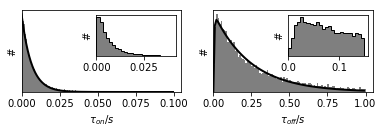

In [123]:
def histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=200, range_on=[0, 0.1], bins_off=100, range_off=[0, 1], plotting=False):
    t_ons = []; t_offs = []; n_on = []; n_off = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot=f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    n_on,bins_on = histogram(t_ons, range=range_on,bins=bins_on);
    n_off,bins_off = histogram(t_offs, range=range_off,bins=bins_off)
    def risetime_fit(t, k1, k2, A):
        return ((A*k1*k2/(k2-k1)) * (exp(-k1*t) - exp(-k2*t)))
    def mono_exp(t, k1, A):
        return A*exp(-k1*t)
    if plotting == True:
        fig, axes = plt.subplots(1, 2, figsize=(6.3, 1.5));
        #HIstogram with zoom in
        from mpl_toolkits.axes_grid.inset_locator import inset_axes
        #------------ON-histogram-------------------
        n_on,bins_on,patches = axes[0].hist(t_ons, range=range_on,bins=bins_on,
                                           color='k', alpha=0.5, label='ON times')
        t=bins_on[:-1]; n = n_on[:];
        fit, pcov = curve_fit(mono_exp, t, n, p0=[10,1.1], bounds=(0, np.inf))
        print('k1:'+str(fit[0]))
        axes[0].plot(t, mono_exp(t, *fit), 'k',lw=2,label='k1:'+str(fit[0])+'\n'+str(fit[1]))
        axes[0].set_xlim(0, None)
        axes[0].set_yticks([])
        axes[0].set_xlabel(r'$\tau_{on}/s$')
        axes[0].set_ylabel('#')
        #axes[0].set_yscale('log')
        #axes[0].set_title("ON time histogram at %s mV" %input_potential[0])
        #axes[0].legend()
        axes0_in = inset_axes(axes[0], height="50%", width="50%")
        axes0_in.hist(t_ons, range=[0, 0.04], bins=25, color='k', alpha=0.5, label='ON times');
        axes0_in.hist(t_ons, range=[0, 0.04], bins=25,color='k', histtype='step');
        axes0_in.set_xlim(0, None)
        axes0_in.set_yticks([])
        axes0_in.set_ylabel('#')
        #------------OFF-histogram-------------------
        n_off,bins_off,patches = axes[1].hist(t_offs, range=range_off,bins=bins_off,
                                             color='k', alpha=0.5, label='ON times')
        t=bins_off[:-1]; n = n_off[:];
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        print('k1:'+str(fit[0])+'\n'+str(fit[1]))
        axes[1].plot(t, risetime_fit(t, *fit), 'k',lw=2,label='k1:'+str(fit[0])+'\n'+str(fit[1]))
        axes[1].set_xlim(0, None)
        axes[1].set_yticks([])
        axes[1].set_xlabel(r'$\tau_{off}/s$')
        axes[1].set_ylabel('#')
        #axes[1].set_yscale('log')
        #axes[1].set_title("OFF time histogram at %s mV" %input_potential[0])
        #axes[1].legend()
        axes1_in = inset_axes(axes[1], height="50%", width="50%")
        axes1_in.hist(t_offs, range=[0, 0.15], bins=25,color='k', alpha=0.5, label='ON times');
        axes1_in.hist(t_offs, range=[0, 0.15], bins=25,color='k', histtype='step');
        axes1_in.set_xlim(0, None)
        axes1_in.set_yticks([]);
        axes1_in.set_ylabel('#')
        return(fig, t_ons, t_offs, n_on, bins_on, n_off, bins_off)
    return(t_ons, t_offs, n_on, bins_on, n_off, bins_off)
fig = histogram_on_off_all_folder(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=200, range_on=[0, 0.1], bins_off=100, range_off=[0, 1], plotting=True);
os.chdir(download);
savefig('many_sm_hist.pdf', dpi=300, transparent=True)

em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


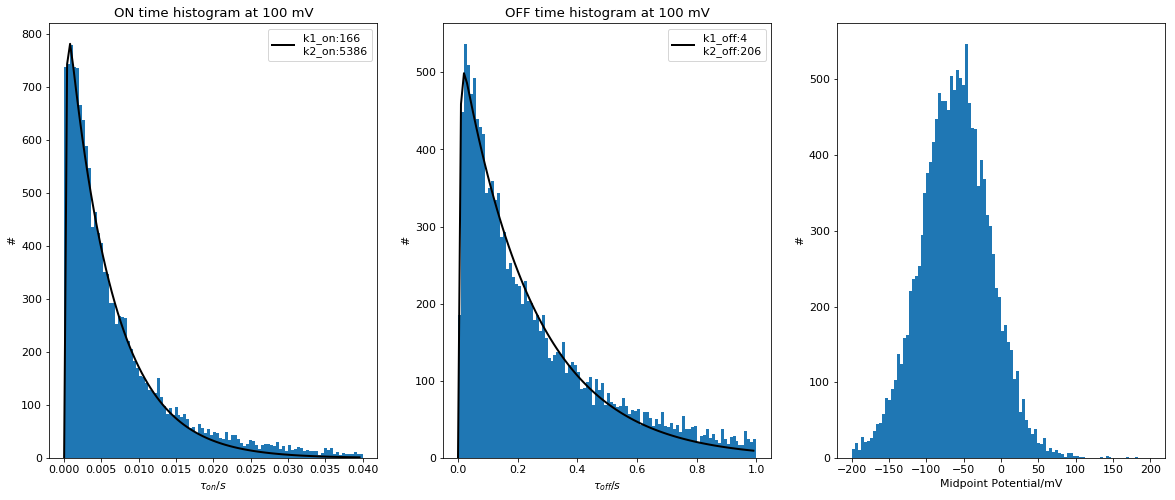

In [10]:
def hist_on_off_all_E0(folderlist= allfolders, input_potential=[100], pointnumbers=range(100),
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5],
                                bins_E0=200, plotting=False):
    t_ons = []; t_offs = []; n_on = []; n_off = [];
    for folder in folderlist:
        df_datn_emplot, df_FCS, folder = dir_mV_molNo(folder)
        df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
        df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
        for i in range(len(df_specific)):
            Point_number = df_specific['Point number'][i]
            f_datn_path = df_specific['filepath[.datn]'].values[i]
            f_emplot_path = df_specific['filepath[.em.plot]'].values[i]
            df_emplot_filename = df_specific['filename[.em.plot]'][i]
            if os.path.isfile(f_emplot_path):
                try:
                    df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot=f_emplot_path)
                except:
                    print('em.plot file: %s doesn''t contain proper data' %df_emplot_filename)
                    df_ton=[]; df_toff=[]
                    pass
            else:
                print('em.plot file of %s with potential %s doesn''t exist' %(Point_number, input_potential))
                df_ton=[]; df_toff=[]
            t_ons = np.concatenate((t_ons, df_ton), axis=0);
            t_offs = np.concatenate((t_offs, df_toff));
    n_on,bins_on = histogram(t_ons, range=range_on,bins=bins_on);
    n_off,bins_off = histogram(t_offs, range=range_off,bins=bins_off)
    def risetime_fit(t, k1, k2, A):
        return ((A*k1*k2/(k2-k1)) * (exp(-k1*t) - exp(-k2*t)))
    if plotting == True:
        fig = plt.figure(figsize=(20,8));
        from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
        from mpl_toolkits.axes_grid1.inset_locator import mark_inset
        nrows=1; ncols= 3;
        ax00 = plt.subplot2grid((nrows,ncols), (0,0));
        ax01 = plt.subplot2grid((nrows,ncols), (0,1));
        ax02 = plt.subplot2grid((nrows,ncols), (0,2));
        #------------ON/OFF histogram-------------------
        n_on,bins_on,patches = ax00.hist(t_ons, range=range_on,bins=bins_on)
        t=bins_on[:-1]; n = n_on[:];
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        ax00.plot(t, risetime_fit(t, *fit), 'k',lw=2,label='k1_on:'+str(int(fit[0]))+
                  '\n'+'k2_on:'+str(int(fit[1])))
        ax00.set_xlabel(r'$\tau_{on}/s$')
        ax00.set_ylabel('#')
        #axes[0].set_yscale('log')
        ax00.set_title("ON time histogram at %s mV" %input_potential[0])
        ax00.legend()
        ax00_in = zoomed_inset_axes(ax00, 6, loc=1)
        
        n_off,bins_off,patches = ax01.hist(t_offs, range=range_off,bins=bins_off)
        t=bins_off[:-1]; n = n_off[:];
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        ax01.plot(t, risetime_fit(t, *fit), 'k',lw=2,label='k1_off:'+str(int(fit[0]))+
                  '\n'+'k2_off:'+str(int(fit[1])))
        ax01.set_xlabel(r'$\tau_{off}/s$')
        ax01.set_ylabel('#')
        #axes[1].set_yscale('log')
        ax01.set_title("OFF time histogram at %s mV" %input_potential[0])
        ax01.legend()
        #------------MidPoint potential-------------
        if len(t_ons)> len(t_offs):
            t_ons = t_ons[:len(t_offs)]
        else:
            t_offs = t_offs[:len(t_ons)]
        t_on_ratio = t_offs/t_ons
        E_0 = potential-59 * log10(t_on_ratio)
        ax02.hist(E_0, bins=bins_E0, range=(-200, 200))
        ax02.set_xlabel('Midpoint Potential/mV')
        ax02.set_ylabel('#')
        plt.close()
    return(fig)
fig = hist_on_off_all_E0(folderlist = allfolders, input_potential=[100], pointnumbers=range(100), 
                        bins_on=100, range_on=[0, 0.04], bins_off=100, range_off=[0, 1],
                         bins_E0=100,plotting=True)

em.plot file of 2.0 with potential [100] doesnt exist
em.plot file of 15.0 with potential [100] doesnt exist


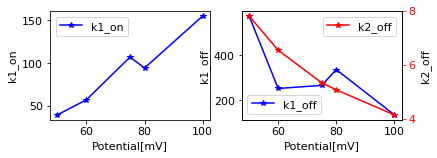

In [114]:
#hist all rates
def risetime_fit(t, k1, k2, A):
    return ((A*k1*k2/(k2-k1)) * (exp(-k1*t) - exp(-k2*t)))
def mono_exp(t, k1, A):
    return A*exp(-k1*t)
columns=['potential','k1_on', 'k1_off', 'k2_off']
df_k = pd.DataFrame(index=None, columns=columns);
df_on_of_hist = pd.DataFrame()
# fig, axes = plt.subplots(2,2, figsize = (12, 5))
potential_list = [100, 90, 80, 75, 70, 60, 50]
def hist_fit_rates(potential_list=[100, 90], folderlist=allfolders, df_k=df_k,
                   t_on_min=0, df_on_of_hist=df_on_of_hist):
    for i in range(len(potential_list)):
        potential=[potential_list[i]]
        t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_all_folder(folderlist= folderlist, input_potential=potential,
                                                                                    pointnumbers=range(100), bins_on=200, range_on=[0, 0.04], bins_off=400, range_off=[0, 1], plotting=False)
        t=bins_on[t_on_min:-1]; n = n_on[t_on_min:]/max(n_on);
        fit, pcov = curve_fit(mono_exp, t, n, p0=[10,1.1], bounds=(0, np.inf))
        n_fit = mono_exp(t, *fit)
#         if fit[0]>fit[1]:
#             k1_on=fit[0]; k2_on=fit[1]
#         else: k1_on=fit[1]; k2_on=fit[0]
        k1_on = fit[0];
        fig, axes = plt.subplots(1,2, figsize = (12, 5))
        axes[0].plot(t, n, 'o',label=str(potential[0])+' mV')
        axes[0].plot(t, mono_exp(t, *fit), 'g',label='k1_on:'+str(int(k1_on)))
        axes[0].set_title("ON time histogram at different potential")
        axes[0].set_xlabel('On times')
        axes[0].set_ylabel('#')
        axes[0].legend()
        #save on-hist to df
        pot_col_name = str(potential[0])+' mV'+'_on';
        tim_col_name = 'time_on'+str(potential);
        fit_col_name = 'fit_on'+str(potential);
        df_on_of_hist[tim_col_name] = pd.Series(t, index=None);
        df_on_of_hist[pot_col_name] = pd.Series(n, index=None);
        df_on_of_hist[fit_col_name] = pd.Series(n_fit, index=None);

        t=bins_off[:-1]; n = n_off/max(n_off)
        fit, pcov = curve_fit(risetime_fit, t, n, p0=[10,1.1, 0.1], bounds=(0, np.inf))
        n_fit = risetime_fit(t, *fit)
        if fit[0]>fit[1]:
            k1_off=fit[0]; k2_off=fit[1]
        else: k1_off=fit[1]; k2_off=fit[0]
        axes[1].plot(t, n,'o', label=str(potential[0])+' mV')
        axes[1].plot(t, risetime_fit(t, *fit), 'g', label='k1_off:'+str(int(k1_off))+'\n'
                    +'k2_off:'+str(int(k2_off)))
        axes[1].set_title("OFF time histogram at different potential")
        axes[1].set_xlabel('On times')
        axes[1].set_ylabel('#')
        axes[1].legend()
        #save off-hist to df
        pot_col_name = str(potential[0])+' mV'+'_off';
        tim_col_name = 'time_off'+str(potential);
        fit_col_name = 'fit_off'+str(potential)
        df_on_of_hist[tim_col_name] = pd.Series(t, index=None);
        df_on_of_hist[pot_col_name] = pd.Series(n, index=None);
        df_on_of_hist[fit_col_name] = pd.Series(n_fit, index=None);
        
        columns=['potential','k1_on', 'k1_off', 'k2_off']
        df_k_temp = pd.DataFrame([[potential[0], k1_on, k1_off, k2_off]], columns=columns);
        df_k = df_k.append(df_k_temp, ignore_index=True)

        plt.close()
    return df_k, df_on_of_hist
##
df_k, df_on_of_hist = hist_fit_rates(potential_list=[100], folderlist=allfolders, df_k=df_k);
df_k, df_on_of_hist = hist_fit_rates(potential_list=[80, 75], folderlist=allfolders, df_k=df_k);
# df_k, pdf, df_on_of_hist = hist_fit_rates(potential_list=[70], folderlist=allfolders, pdf=pdf, df_k=df_k, t_on_min=1);
df_k, df_on_of_hist = hist_fit_rates(potential_list=[60], folderlist=allfolders, df_k=df_k);
df_k, df_on_of_hist = hist_fit_rates(potential_list=[50], folderlist=allfolders, df_k=df_k, t_on_min=2);
##
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "10"

fig1, axes = plt.subplots(1,2, figsize = (6.3, 2))
axes[0].plot(df_k['potential'], df_k['k1_on'], 'b-*', label='k1_on')
axes[0].set_xlabel('Potential[mV]')
axes[0].set_ylabel('k1_on')
# ax1_r = axes[0].twinx()
# ax1_r.plot(df_k['potential'], df_k['k2_on'], 'r-*', label='k2_on')
# ax1_r.tick_params('y', colors='r')

axes[1].plot(df_k['potential'], df_k['k1_off'], 'b-*', label='k1_off')
axes[1].set_xlabel('Potential[mV]')
axes[1].set_ylabel('k1_off')
axes[1].tick_params('y', colors='b')
ax2_r = axes[1].twinx()
ax2_r.plot(df_k['potential'], df_k['k2_off'], 'r-*', label='k2_off')
ax2_r.tick_params('y', colors='r')
ax2_r.set_ylabel('k2_off')
axes[0].legend(loc=2); axes[1].legend(loc=3);ax2_r.legend(loc=1)

fig1.tight_layout()
os.chdir(download)
savefig('k_rates_vs_potential.pdf', dpi=300, transparent=True)

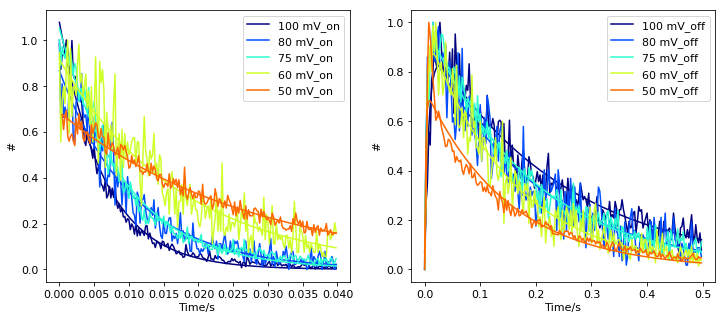

In [107]:
pot_len = shape(df_on_of_hist)[1]/6;
col_values = list(df_on_of_hist.columns.values);
fig_all_hist, axes = plt.subplots(1,2, figsize = (12, 5))
cmap = plt.get_cmap('jet')#jet_r
N=pot_len
for i in range(int(pot_len)):
    color = cmap(float(i)/N)
    j=6*i;
    axes[0].plot(df_on_of_hist.iloc[:,j], df_on_of_hist.iloc[:, j+1], color=color, label=col_values[j+1])
    axes[0].plot(df_on_of_hist.iloc[:,j], df_on_of_hist.iloc[:, j+2], color=color, label='')
    axes[0].set_xlabel('Time/s')
    axes[0].set_ylabel('#')    
    axes[0].legend()
    
    axes[1].plot(df_on_of_hist.iloc[:, j+3], df_on_of_hist.iloc[:, j+3+1], color=color, label=col_values[j+4])
    axes[1].plot(df_on_of_hist.iloc[:, j+3], df_on_of_hist.iloc[:,j+3+2], color=color, label='')
    axes[1].set_xlabel('Time/s')
    axes[1].set_ylabel('#')    
    axes[1].legend()
os.chdir(download)
savefig('rate_fit_all_potential.pdf', dpi=300, transparent=True)

## Ton_Toff Histogram: Figure 4

In [239]:
def histogram_on_off_1mol(foldername= foldername, input_potential=[100], pointnumbers=[1],
                          bins_on=50, range_on=[0, 0.2], bins_off=50, range_off=[0, 0.5], plotting=False, sum_points=10):
    df_datn_emplot, df_FCS, folder = dir_mV_molNo(foldername)
    df_specific = df_datn_emplot[df_datn_emplot['Point number'].isin(pointnumbers)]#keep all the points that exist
    df_specific = df_specific[df_specific['Potential'].isin(input_potential)]; df_specific.reset_index(drop=True, inplace=True)
    f_emplot_path = 'x'; f_datn_path='x'; t_ons=[];t_offs=[]
    if not df_specific.empty:
        f_datn_path = df_specific['filepath[.datn]'].values[0]
        f_emplot_path = df_specific['filepath[.em.plot]'].values[0]
    if os.path.isfile(f_emplot_path):
        df_ton, df_toff, average_ton, average_toff, average_ton_err, average_toff_err = t_on_off_fromCP(f_emplot_path)
        t_ons = np.array(df_ton);
        t_offs = np.array(df_toff)
        n_on = []; n_off = []
        if plotting == True:
            fig = plt.figure(figsize=(6.3, 6))
            nrows=3; ncols= 2;
            ax00 = plt.subplot2grid((nrows,ncols), (0,0));
            ax01 = plt.subplot2grid((nrows,ncols), (0,1));
            ax1 = plt.subplot2grid((nrows, ncols), (1,0), colspan=2)
            ax2 = plt.subplot2grid((nrows, ncols), (2,0), colspan=2)
            #ax3 = plt.subplot2grid((nrows, ncols), (3,0), colspan=2)

            n_on,bins_on,patches = ax00.hist(t_ons, range=range_on, bins=bins_on, color='k', alpha=0.5, label='ON times')
            n_on,bins_on,patches = ax00.hist(t_ons, range=range_on, bins=bins_on, color='k', histtype='step')
            ax00.set_xlabel(r'$\tau_{on}/s$')
            ax00.set_ylabel('PDF')
            ax00.set_xlim(0, None)
            ax00.yaxis.set_ticklabels([])
            ax00.legend()
            #ax00.set_yscale('log')
            n_off,bins_off,patches = ax01.hist(t_offs, range=range_off,bins=bins_off, color='k', alpha=0.5, label='OFF times')
            n_off,bins_off,patches = ax01.hist(t_offs, range=range_off,bins=bins_off, color='k', histtype='step')
            ax01.set_xlabel(r'$\tau_{off}/s$')
            ax01.yaxis.set_ticklabels([])
            ax01.set_xlim(0, None)
            ax01.legend()
            #ax01.set_yscale('log')
            #ax01.set_title("OFF time histogram at %s mV" %input_potential[0])
            if len(t_ons)> len(t_offs):
                t_ons = t_ons[:len(t_offs)]
            else:
                t_offs = t_offs[:len(t_ons)]

            t_av_on = []; t_av_off = []; t_abs = [];
            start=0;
            num_outputs = int(len(t_ons)/sum_points);
            for i in range(num_outputs):
                t_av_on_temp = sum(t_ons[start:start+sum_points])
                t_av_of_temp = sum(t_offs[start:start+sum_points])
                start += sum_points
                t_av_on.append(t_av_on_temp)
                t_av_off.append(t_av_of_temp)
                t_abs_temp = sum(t_ons[:start+sum_points]) + sum(t_offs[:start+sum_points])
                t_abs.append(t_abs_temp)
            t_av_on = pd.Series(t_av_on);
            t_av_off = pd.Series(t_av_off)

            t_on_ratio = t_av_off/t_av_on;

            ax1.plot(t_abs, t_av_on, 'b', label='On_av')
            ax1.set_ylim(0, 5)
            ax1.set_xlim(0, None)
            ax1.tick_params('y', colors='b')
            ax1.set_ylabel('ton_av/s', color='b')
            ax1.set_xticks([])
            ax1.legend(loc='center right')
            ax1_r = ax1.twinx()
            
            ax1_r.plot(t_abs, t_av_off, 'r',label='Off_av')
            ax1_r.tick_params('y', colors='r')
            ax1_r.set_ylabel('toff_av/s', color='r')
            ax1_r.set_ylim(-5, 8)#BE CAREFUL of this limit
            ax1_r.set_xlim(0, None)
            #ax1_r.set_xlabel('time/s')
            ax1_r.set_xticks([])
            ax1_r.legend(loc='center')
            #ax2_r = ax1_r.twinx()
            #ax2_r.plot(t_abs,range(len(t_abs)), 'g', label='$reduced_- ascorbate$')
            #ax2_r.tick_params('y', colors='g')
            #ax2_r.set_xticks([])

            E_0 = potential-59 * log10(t_on_ratio)
            ax2.plot(t_abs, E_0)
            ax2.set_xlabel('time/s')
            ax2.set_ylabel('E_0[mV]')
            ax2.set_ylim(-50, 50)
            ax2.set_xlim(0, None)
            
            fig.tight_layout()
    return(t_av_on, t_av_off, n_on, bins_on, n_off, bins_off)

### 50mV : Point_16/ 1900 s

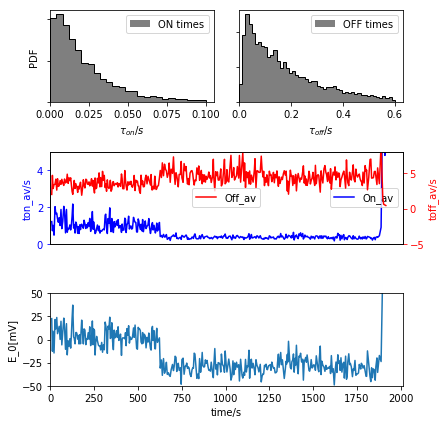

In [240]:
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime/';#data directory
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_1mol(foldername= homedir, input_potential=[50], pointnumbers=[16],
                                                                      bins_on=25, range_on=[0, 0.1], bins_off=50, range_off=[0, 0.6], plotting=True, sum_points=20)
os.chdir(download)
savefig('SM_statistics.pdf', dpi=300, transparent=True)

## Ton_Toff histogram: 2D: Figure_5

Number of on events: 7896
Number of off events: 7894


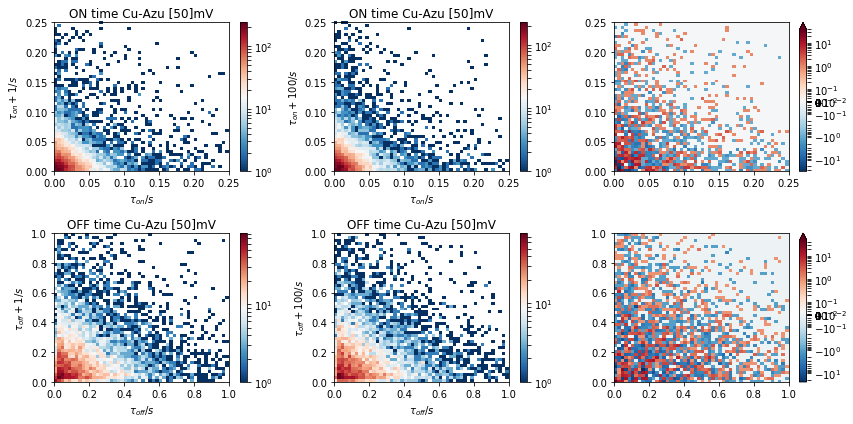

In [43]:
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "10"
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime/';#data directory
C_on_diff, C_off_diff = hist2D_on_off(foldername=homedir, input_potential=[50], pointnumbers=[16], bins_on=20, range_on=[0, 0.25],
                                      bins_off=20, range_off=[0, 1], x_shift=100, plots=True, figsize=(12, 6))
os.chdir(download)
savefig('Figure_4part_on_off_2D_100mV.pdf', dpi=300, transparent=True)

## Dynamics rate

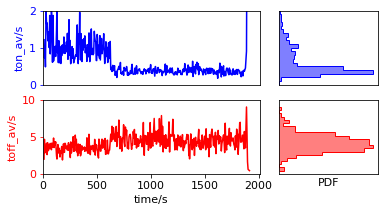

In [34]:
#dynamics from the same trace
homedir=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/S105d15May17_60.5%635_A1_CuAzu655_longtime/';#data directory
t_ons, t_offs, n_on, bins_on, n_off, bins_off = histogram_on_off_1mol(foldername= homedir, input_potential=[50], pointnumbers=[16],
                          bins_on=50, range_on=[0, 0.01], bins_off=100, range_off=[0, 1], plotting=False)

sum_points = 20;
num_outputs = int(len(t_ons)/sum_points)
start = 0;
t_av_on = []; t_av_off = []; t_abs = [];
for i in range(num_outputs):
    t_av_on_temp = sum(t_ons[start:start+sum_points])
    t_av_of_temp = sum(t_offs[start:start+sum_points])
    start += sum_points
    t_av_on.append(t_av_on_temp)
    t_av_off.append(t_av_of_temp)
    t_abs_temp = sum(t_ons[:start+sum_points]) + sum(t_offs[:start+sum_points])
    t_abs.append(t_abs_temp)
t_av_on = pd.Series(t_av_on);
t_av_off = pd.Series(t_av_off)

figure(figsize=(6, 3))
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "11"

ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, label='ax1')
ax1.plot(t_abs, t_av_on, 'b')
ax1.set_ylim(0, 2)
ax1.set_xlim(0, None)
ax1.tick_params('y', colors='b')
ax1.set_ylabel('ton_av/s', color='b')
ax1.set_xticks([])
ax2 = plt.subplot2grid((2, 3), (0, 2), colspan=1)
ax2.hist(t_av_on,bins=20, range=(0,2), orientation='horizontal', color='b', alpha=0.5)
ax2.hist(t_av_on,bins=20, range=(0,2), orientation='horizontal', color='b', histtype='step', lw=1)
ax2.set_ylim(0, 2)
ax2.set_xticks([]); ax2.set_yticks([])

ax3 = plt.subplot2grid((2, 3), (1, 0), colspan=2)
ax3.plot(t_abs, t_av_off, 'r')
ax3.tick_params('y', colors='r')
ax3.set_ylabel('toff_av/s', color='r')
ax3.set_ylim(0, 10)#BE CAREFUL of this limit
ax3.set_xlim(0, None)
ax3.set_xlabel('time/s')
ax4 = plt.subplot2grid((2, 3), (1, 2))
ax4.hist(t_av_off,bins=20, orientation='horizontal', color='r', alpha=0.5)
ax4.hist(t_av_off,bins=20, orientation='horizontal', color='r', histtype='step', lw=1)
ax4.set_xticks([]); ax4.set_yticks([])
ax4.set_ylim(0, 10)#BE CAREFUL of this limit
ax4.set_xlabel('PDF')
# tight_layout()
os.chdir(download)
savefig('dynamic_rates.pdf', dpi=300, trasparent = True)

## Life time

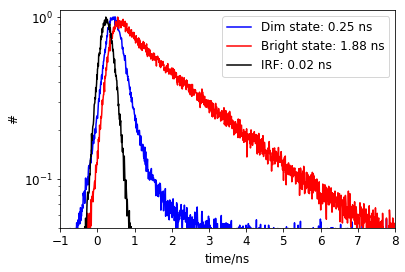

In [136]:
#lifetime
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/lifetime')
file_oxd='Point_A1_100mV(10)_60.5_1200s_24_lifetime_oxd.dat'
file_red='Point_A1_050mV(7)_60.5_1920s_16_reduced.dat'
file_irf = 'irf_20170511_lowpower.dat'
file_Zn = 'Point_A5_025mV(29)_60.5_260s_10_Zn_lifetiem.dat'
d_oxd= pd.read_csv(file_oxd, header=None, sep='\t', skiprows=10)
d_red = pd.read_csv(file_red, header=None, sep='\t', skiprows=10)
d_irf = pd.read_csv(file_irf, header=None, sep='\t', skiprows=10)
d_Zn = pd.read_csv(file_Zn, header=None, sep='\t', skiprows=10)
x_offset = 4.5;
fig, ax = plt.subplots(figsize=(6,4))
mpl.rcParams["font.family"] = "sans-serif"
fontsize = 12
ax.plot(d_oxd[0]-x_offset, d_oxd[2]/max(d_oxd[2]), 'b', label='Dim state: 0.25 ns')
ax.plot(d_red[0]-x_offset, d_red[2]/max(d_red[2]), 'r', label='Bright state: 1.88 ns')
ax.plot(d_irf[0]-x_offset, d_irf[2]/max(d_irf[2]), 'k', label='IRF: 0.02 ns')
# ax.plot(d_Zn[0]-x_offset, d_Zn[2]/max(d_Zn[2]), 'g', label='ZnAzurin: 2.1 ns')
ax.set_yscale('log')
ax.set_xlim(-1, 8)
ax.set_ylim(0.05, 1.1)
ax.set_xlabel('time/ns', fontsize=fontsize)
ax.set_ylabel('#', fontsize=fontsize)
ax.tick_params(axis='both', labelsize=fontsize)
ax.legend(fontsize=fontsize)
os.chdir(download)
savefig('lifetime.pdf', dpi=300, transparent=True)

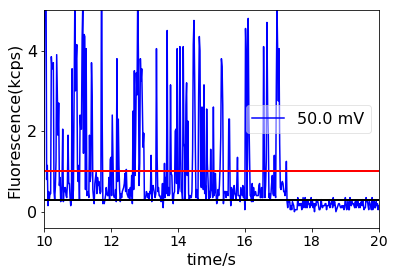

In [153]:
#corresponding time trace
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.size"] = "14"
folder=r'/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/lifetime'
fig = time_trace_plot(foldername= folder, input_potential=[50], pointnumbers=[3], x_lim_min=10, y_lim_min=0,
                      x_lim_max=20, y_lim_max=5, bin=20, show_changepoint=False, figsize=(6,4))
plot(linspace(10,20,10), ones(10)*1, 'r', lw=2, label='threshold')
plot(linspace(10,20,10), ones(10)*0.3, 'k', lw=2, label='threshold')
ylim(-0.4, None)
# legend(fontsize = 16)
os.chdir(download)
savefig('lifetime_timetrace.pdf', dpi=300, transparent=True)

## Image

In [105]:
# Image at oxidizing and redux-cing condition
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/image')
f_oxd = 'S81d7Sept16_0.53uW_0.2mMFerri_0.1mM Asc_200mV(22)_A2_again.dat';
f_red = 'S81d7Sept16_0.53uW_0.2mMFerri_0.1mM Asc_-50mV(23)_A2_again.dat';
d_oxd= pd.read_csv(f_oxd, header=None, sep='\s+', skiprows=8)
d_red= pd.read_csv(f_red, header=None, sep='\s+', skiprows=8)
# d_oxd
fig, axes = plt.subplots(2,1,figsize=(4,8))
color = "hot"
axes[0].imshow(d_oxd, cmap=color, vmin=0, vmax=20, aspect='equal')
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].imshow(d_red, cmap=color, vmin=0, vmax=20, aspect='equal')
axes[1].set_xticks([])
axes[1].set_yticks([])
os.chdir(download)
savefig('image_onoff.pdf', dpi=300, transparent=True)

## fcs components

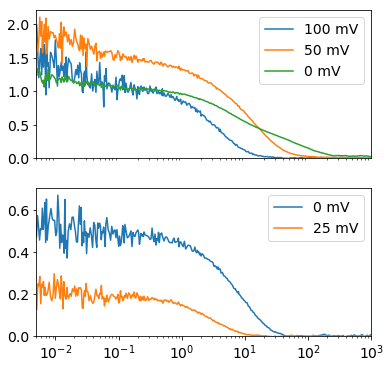

In [194]:
#fcs components
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/fcs_component/');
f_100 = 'Point_A9_100mV(18)_60.5_1600s_26_FCS1.dat';
f_50 = 'Point_A8_050mV(15)_60.5_1980s_22_FCS1.dat';
f_0 = 'Point_A6_000mV(9)_60.5_1260s_10_FCS1.dat';
f_Zn_0 = 'Point_0.11uW_A3_ZnAzu_0mV(21)_200sec_27_FCS1.dat';
f_Zn_25 = 'Point_A5_ZnAzu_025mV(29)_60.5_260s_10_FCS1.dat';
#----
tmin = 0.005;tmax = 1000;
fig, axes = plt.subplots(2,1, figsize=(6, 6))
#---100 mV
df_fcs = pd.read_csv(f_100, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_100 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_100[0],f_100[1], '-', label='100 mV')
#---50 mV
df_fcs = pd.read_csv(f_50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_50[0],f_50[1], '-', label='50 mV')
#---
df_fcs = pd.read_csv(f_0, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_0 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_0[0],f_0[1], '-', label='0 mV')

axes[0].set_xscale('log')
axes[0].set_ylim(0, None)
axes[0].set_xlim(tmin, tmax)
axes[0].set_xticks([])
axes[0].legend()
#--ZnAzu 0 mV---
df_fcs = pd.read_csv(f_Zn_0, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_0 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_0[0],f_Zn_0[1], '-', label='0 mV')
#ZnAzu 25 mV---
df_fcs = pd.read_csv(f_Zn_25, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_25 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_25[0],f_Zn_25[1], '-', label='25 mV')

axes[1].set_xscale('log')
axes[1].set_ylim(0, None)
axes[1].set_xlim(tmin, tmax)
axes[1].legend()

os.chdir(download)
savefig('fcs_components.pdf', dpi=300, transparent=True)

## fcs comparision

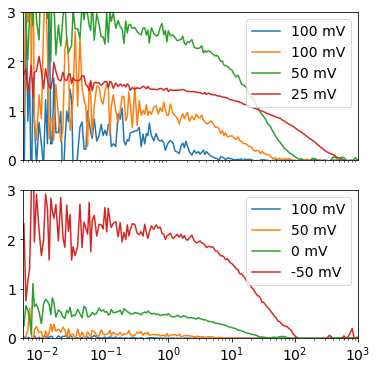

In [195]:
#fcs components
os.chdir('/home/biswajit/Research/Reports_ppt/reports/AzurinSM-MS4/data/1misc/fcs_comparision/');
# CuAzurin files
f_Cu_150 = 'CuAzu/Point_0.11uW_A3_150mV_6_FCS1.dat';
f_Cu_100 = 'CuAzu/Point_0.11uW_A3_100mV_6_FCS1.dat';
f_Cu_50 = 'CuAzu/Point_0.11uW_A3_50mV_6_FCS1.dat';
f_Cu_25 = 'CuAzu/Point_0.11uW_A3_25mV_300s_6_FCS1.dat';
#ZnAzurin files
f_Zn_100 = 'ZnAzu/Point_0.11uW_A4_100mV(33)_30sec_2_FCS1.dat';
f_Zn_50 = 'ZnAzu/Point_0.11uW_A4_50mV(32)_30sec_1_FCS1.dat';
f_Zn_0 = 'ZnAzu/Point_0.11uW_A4_0mV(31)_30sec_1_FCS1.dat';
f_Zn_n50 = 'ZnAzu/Point_0.11uW_A4_-50mV(30)_30sec_1_FCS1.dat';
#----
tmin = 0.005;tmax = 1000;
fig, axes = plt.subplots(2,1, figsize=(6, 6))
#--150 mV
df_fcs = pd.read_csv(f_Cu_150, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_150 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_150[0],f_150[1], '-', label='100 mV')

#---100 mV
df_fcs = pd.read_csv(f_Cu_100, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_100 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_100[0],f_100[1], '-', label='100 mV')
#---50 mV
df_fcs = pd.read_csv(f_Cu_50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_50[0],f_50[1], '-', label='50 mV')
#---25 mV
df_fcs = pd.read_csv(f_Cu_25, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_25 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[0].plot(f_25[0],f_25[1], '-', label='25 mV')

axes[0].set_xscale('log')
axes[0].set_ylim(0, 3)
axes[0].set_xlim(tmin, tmax)
axes[0].set_xticks([])
axes[0].legend()
#ZnAzu 100 mV---
df_fcs = pd.read_csv(f_Zn_100, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_100 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_100[0],f_Zn_100[1], '-', label='100 mV')
#ZnAzu 50 mV---
df_fcs = pd.read_csv(f_Zn_50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_50[0],f_Zn_50[1], '-', label='50 mV')

#--ZnAzu 0 mV---
df_fcs = pd.read_csv(f_Zn_0, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_0 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_0[0],f_Zn_0[1], '-', label='0 mV')
#--ZnAzu -50 mV---
df_fcs = pd.read_csv(f_Zn_n50, index_col=False, names=None, skiprows=1, header=None, sep='\s+');
f_Zn_n50 = df_fcs[df_fcs[0]>=tmin]; df_fcs = df_fcs[df_fcs[0]<=tmax];
axes[1].plot(f_Zn_n50[0],f_Zn_n50[1], '-', label='-50 mV')

axes[1].set_xscale('log')
axes[1].set_ylim(0, 3)
axes[1].set_xlim(tmin, tmax)
axes[1].legend()

os.chdir(download)
savefig('fcs_comparision_smae_mol.pdf', dpi=300, transparent=True)